In [1]:
import pandas as pd
from datetime import date, timedelta
import win32com.client as win32
import teradatasql
import seaborn as sns
from phik.report import plot_correlation_matrix
from phik import report
import matplotlib.pyplot as plt
import pygwalker as pyg
import folium 
from folium.plugins import MarkerCluster, HeatMap
import requests
from xml.etree import ElementTree
import numpy as np

c:\Users\vitaly.flerin\Miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\vitaly.flerin\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\vitaly.flerin\Miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
password = '****'
user="vitaly.****"
query = '''select * from uat_ca.vf_rostov_research_17052023'''

In [3]:
with teradatasql.connect(host="td2800.corp.tele2.ru", user=user, password='4GyyERMq!!!',logmech="ldap", tmode="TERA" ) as connect:
    df = pd.read_sql(query, connect)
df

C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_8896\1641996674.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connect)


,subs_id,sector_name,BS_POSITION,coeff_80,top_3,coeff_80_new,LON,LAT,ST_POINT
0,55797664.0,RO3303_3,POINT (40.309194 46.8405),0.084357,1,8.43572963308699E-002,40.309194,46.840500,POINT (40.309194 46.8405)
1,24402038.0,RO0444_3,POINT (39.295194 47.283083),0.024826,2,2.48256231599057E-002,39.295194,47.283083,POINT (39.295194 47.283083)
2,2385623.0,RO2925_012,POINT (39.75123 47.297701),0.002102,1,2.10199584958692E-003,39.751230,47.297701,POINT (39.75123 47.297701)
3,35108986.0,RO0431_3,POINT (38.871306 47.215083),0.018102,2,1.81018704177780E-002,38.871306,47.215083,POINT (38.871306 47.215083)
4,47200691.0,RO3308_2,POINT (41.538889 46.456389),0.017426,2,1.74256714339643E-002,41.538889,46.456389,POINT (41.538889 46.456389)
...,...,...,...,...,...,...,...,...,...
43718,43201069.0,RO5218_3,POINT (39.815897 47.350865),0.016347,2,1.63466002214032E-002,39.815897,47.350865,POINT (39.815897 47.350865)
43719,64302687.0,RO0522_3,POINT (40.082111 47.423306),0.008179,1,8.17852207717059E-003,40.082111,47.423306,POINT (40.082111 47.423306)
43720,43201069.0,RO0821_015,POINT (39.78888 47.346406),0.035219,1,3.52185476472344E-002,39.788880,47.346406,POINT (39.78888 47.346406)
43721,64302687.0,RO3522_3,POINT (40.082111 47.423306),0.005907,2,5.90724660794597E-003,40.082111,47.423306,POINT (40.082111 47.423306)


c:\Users\vitaly.flerin\Miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: xlabel='LON', ylabel='LAT'>

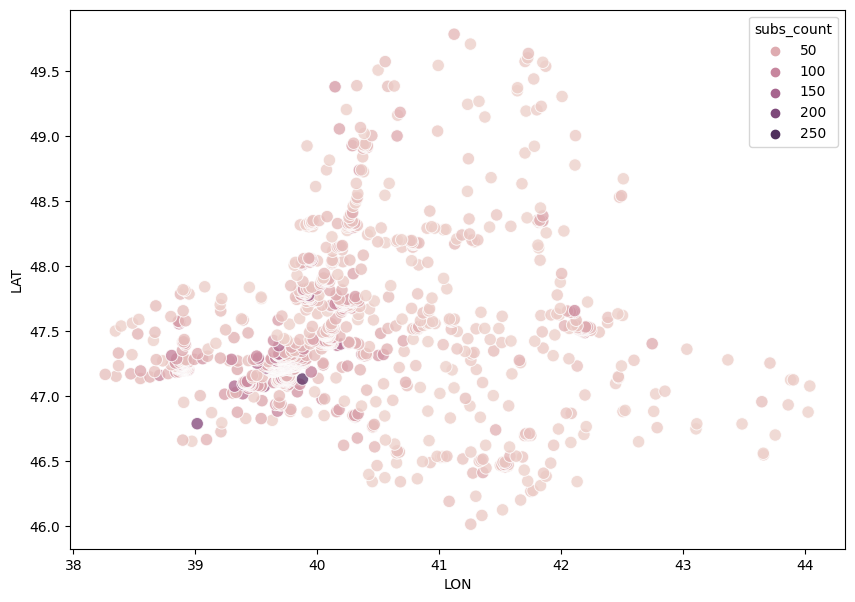

In [4]:
# Создаем датафрейм для распределения подписчиков по регионам
df_subs_count = df.groupby(['LAT', 'LON', 'ST_POINT'], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})

# Создаем scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_subs_count, x='LON', y='LAT', hue='subs_count', cmap='cool', s=80, alpha=0.8)


In [6]:
#df.query('ST_POINT == "POINT (41.695226 46.431515)"').groupby(['LAT', 'LON', 'ST_POINT', 'sector_name'], as_index=False)['subs_id'].count().sort_values(by = 'subs_id', ascending=False).head(30).to_excel('fgd.xlsx')

In [9]:
#df_subs_count.sort_values(by = 'subs_count', ascending=True).head(10)

<Axes: >

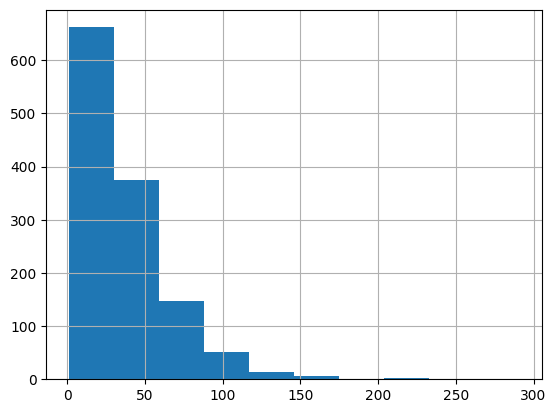

In [10]:
df_subs_count.sort_values(by = 'subs_count', ascending=False).subs_count.hist()

In [11]:
#находим выбросы через интеркваритальный размах
Q1 = df_subs_count["subs_count"].quantile(0.25)
Q3 = df_subs_count["subs_count"].quantile(0.75)
IQR = Q3 - Q1

# Определение границ выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Нахождение выбросов
outliers = df_subs_count[(df_subs_count['subs_count'] < lower_bound) | (df_subs_count['subs_count'] > upper_bound)]
outliers.subs_count.sort_values(ascending=True).head(5)

694    106
338    106
563    108
726    108
264    108
Name: subs_count, dtype: int64

In [14]:
#добавляем интерактив
# Создаем датафрейм, группируем абонентов по локациям
df_subs_count = df.groupby(['LAT', 'LON','ST_POINT' ], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})
# Создаем карту
m = folium.Map(location=[df_subs_count['LAT'].mean(), df_subs_count['LON'].mean()], zoom_start=5)
# Создаем точечные маркеры для каждой точки и добавляем их на карту
for i, row in df_subs_count.iterrows():
    if row['subs_count'] >= 106:
        color = 'red'
    elif row['subs_count'] > 50 and row['subs_count'] < 109:
        color = 'blue'
    else:
        color = 'green'
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=row['subs_count']/10,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip="cnt_subs: " + str(row['subs_count']) + '    Geo:' + row['ST_POINT']
    ).add_to(m)
m#.save("map_17_05.html")

In [15]:
#тепловая в.1
locationlist = df[['LAT', 'LON']].values.tolist()
map3 = folium.Map(location=[55.62252, 37.30162], tiles='CartoDB dark_matter', zoom_start=5)
heat_df = df[['LAT', 'LON']]
heat_data = [[row['LAT'],row['LON']] for index, row in heat_df.iterrows()]
# Изменяем настройки цветовой схемы, используя параметр gradient
HeatMap(heat_data, radius=15, gradient={.1: 'blue', .2: 'lime', 1: 'red'}).add_to(map3)
map3#.save("Heat_map_17_05.html")

Абоненты HWE

In [16]:
user="vitaly****"
password="***!"
query = '''select * from uat_ca.vf_rostov_research_17052023_hwe'''

In [17]:
with teradatasql.connect(host="td2800.corp.tele2.ru", user=user, password=password,logmech="ldap", tmode="TERA" ) as connect:
    df_hwe = pd.read_sql(query, connect)
df_hwe

C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_8896\4269897363.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_hwe = pd.read_sql(query, connect)


,hwe_sector,subs_id,sector_name,BS_POSITION,coeff_80,top_3,coeff_80_new,LON,LAT,ST_POINT,REPORT_DATE,HOME_SECTOR,subs_id_hwe
0,RO3303_3,55797664.0,RO3303_3,POINT (40.309194 46.8405),0.084357,1,8.43572963308699E-002,40.309194,46.840500,POINT (40.309194 46.8405),2023-03-01,RO0303_3,55797664.0
1,RO0444_3,24402038.0,RO0444_3,POINT (39.295194 47.283083),0.024826,2,2.48256231599057E-002,39.295194,47.283083,POINT (39.295194 47.283083),2023-03-01,RO0444_2,24402038.0
2,RO2925_012,2385623.0,RO2925_015,POINT (39.75123 47.297701),0.001073,3,1.07277320344230E-003,39.751230,47.297701,POINT (39.75123 47.297701),2023-03-01,RO2925_2,2385623.0
3,RO3403_2,35108986.0,RO3403_8,POINT (38.8635 47.22175),0.007888,3,7.88767312757382E-003,38.863500,47.221750,POINT (38.8635 47.22175),2023-03-01,RO0403_2,35108986.0
4,RO3308_2,47200691.0,RO3308_2,POINT (41.538889 46.456389),0.017426,2,1.74256714339643E-002,41.538889,46.456389,POINT (41.538889 46.456389),2023-03-01,RO1121_3,47200691.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43718,RO3821_2,43201069.0,RO3821_2,POINT (39.78888 47.346406),0.016278,3,1.62780113783994E-002,39.788880,47.346406,POINT (39.78888 47.346406),2023-03-01,RO0821_012,43201069.0
43719,RO0522_3,64302687.0,RO0522_3,POINT (40.082111 47.423306),0.008179,1,8.17852207717059E-003,40.082111,47.423306,POINT (40.082111 47.423306),2023-03-01,RO3522_3,64302687.0
43720,RO0821_012,43201069.0,RO0821_015,POINT (39.78888 47.346406),0.035219,1,3.52185476472344E-002,39.788880,47.346406,POINT (39.78888 47.346406),2023-03-01,RO0821_012,43201069.0
43721,RO3285_2,64302687.0,RO3285_8,POINT (39.877078 47.131604),0.004476,3,4.47586934064436E-003,39.877078,47.131604,POINT (39.877078 47.131604),2023-03-01,RO3522_3,64302687.0


In [18]:
df_hwe_copy = df_hwe.copy()
def flag(row):
    if row['hwe_sector'] == row['HOME_SECTOR']:
        return "1"
    else:
        return "0"
df_hwe_copy['flag'] = df_hwe_copy.apply(flag,axis =1)

In [19]:
df_hwe_copy

,hwe_sector,subs_id,sector_name,BS_POSITION,coeff_80,top_3,coeff_80_new,LON,LAT,ST_POINT,REPORT_DATE,HOME_SECTOR,subs_id_hwe,flag
0,RO3303_3,55797664.0,RO3303_3,POINT (40.309194 46.8405),0.084357,1,8.43572963308699E-002,40.309194,46.840500,POINT (40.309194 46.8405),2023-03-01,RO0303_3,55797664.0,0
1,RO0444_3,24402038.0,RO0444_3,POINT (39.295194 47.283083),0.024826,2,2.48256231599057E-002,39.295194,47.283083,POINT (39.295194 47.283083),2023-03-01,RO0444_2,24402038.0,0
2,RO2925_012,2385623.0,RO2925_015,POINT (39.75123 47.297701),0.001073,3,1.07277320344230E-003,39.751230,47.297701,POINT (39.75123 47.297701),2023-03-01,RO2925_2,2385623.0,0
3,RO3403_2,35108986.0,RO3403_8,POINT (38.8635 47.22175),0.007888,3,7.88767312757382E-003,38.863500,47.221750,POINT (38.8635 47.22175),2023-03-01,RO0403_2,35108986.0,0
4,RO3308_2,47200691.0,RO3308_2,POINT (41.538889 46.456389),0.017426,2,1.74256714339643E-002,41.538889,46.456389,POINT (41.538889 46.456389),2023-03-01,RO1121_3,47200691.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43718,RO3821_2,43201069.0,RO3821_2,POINT (39.78888 47.346406),0.016278,3,1.62780113783994E-002,39.788880,47.346406,POINT (39.78888 47.346406),2023-03-01,RO0821_012,43201069.0,0
43719,RO0522_3,64302687.0,RO0522_3,POINT (40.082111 47.423306),0.008179,1,8.17852207717059E-003,40.082111,47.423306,POINT (40.082111 47.423306),2023-03-01,RO3522_3,64302687.0,0
43720,RO0821_012,43201069.0,RO0821_015,POINT (39.78888 47.346406),0.035219,1,3.52185476472344E-002,39.788880,47.346406,POINT (39.78888 47.346406),2023-03-01,RO0821_012,43201069.0,1
43721,RO3285_2,64302687.0,RO3285_8,POINT (39.877078 47.131604),0.004476,3,4.47586934064436E-003,39.877078,47.131604,POINT (39.877078 47.131604),2023-03-01,RO3522_3,64302687.0,0


In [20]:
df_hwe_copy.subs_id_hwe.nunique() # уникальных абонов

14575

In [21]:
df_hwe_copy[df_hwe_copy['flag'] == "1"].subs_id.nunique()  # уникальных абонов, у которых место жительства совпадает с плохим сектором из топ 3

9202

c:\Users\vitaly.flerin\Miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: xlabel='LON', ylabel='LAT'>

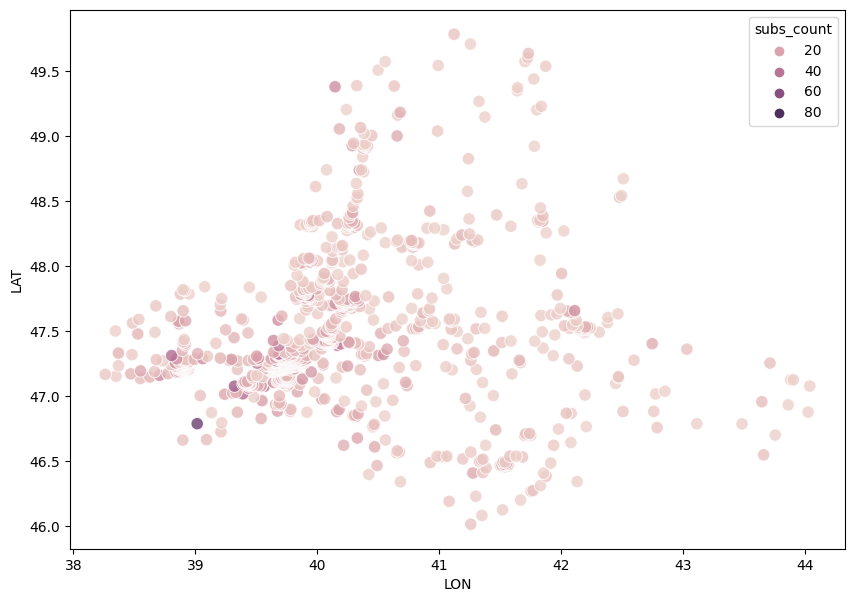

In [22]:
# Создаем датафрейм для распределения подписчиков по регионам
df_subs_count = df_hwe_copy.query('flag == "1"').groupby(['LAT', 'LON', 'ST_POINT'], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})

# Создаем scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_subs_count, x='LON', y='LAT', hue='subs_count', cmap='cool', s=80, alpha=0.8)

In [23]:
df_subs_count.sort_values(by='subs_count', ascending=False ) # распределение

,LAT,LON,ST_POINT,subs_count
375,47.230621,39.596564,POINT (39.596564 47.230621),92
76,46.788556,39.014667,POINT (39.014667 46.788556),70
132,47.076833,39.320361,POINT (39.320361 47.076833),51
412,47.237333,39.811944,POINT (39.811944 47.237333),48
656,47.321011,39.688735,POINT (39.688735 47.321011),44
...,...,...,...,...
128,47.038266,42.848704,POINT (42.848704 47.038266),1
1101,48.340512,39.952773,POINT (39.952773 48.340512),1
126,47.033419,39.977056,POINT (39.977056 47.033419),1
534,47.267002,39.853668,POINT (39.853668 47.267002),1


<Axes: >

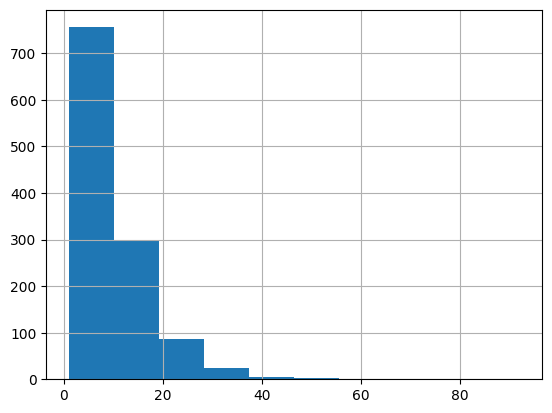

In [24]:
df_subs_count.subs_count.hist()

In [25]:
#находим выбросы
Q1 = df_subs_count["subs_count"].quantile(0.25)
Q3 = df_subs_count["subs_count"].quantile(0.75)
IQR = Q3 - Q1

# Определение границ выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Нахождение выбросов
outliers = df_subs_count[(df_subs_count['subs_count'] < lower_bound) | (df_subs_count['subs_count'] > upper_bound)]
outliers.subs_count.sort_values(ascending=True).head(5)

851    27
715    27
610    27
597    27
237    27
Name: subs_count, dtype: int64

In [26]:
#добавляем интерактив
# Создаем датафрейм для распределения подписчиков по регионам
df_subs_count = df_hwe_copy.query('flag == "1"').groupby(['LAT', 'LON', 'ST_POINT'], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})
# Создаем карту
m = folium.Map(location=[df_subs_count['LAT'].mean(), df_subs_count['LON'].mean()], zoom_start=5)
# Создаем точечные маркеры для каждой точки и добавляем их на карту
for i, row in df_subs_count.iterrows():
    if row['subs_count'] >= 27:
        color = 'red'
    elif row['subs_count'] > 15 and row['subs_count'] < 27:
        color = 'blue'
    else:
        color = 'green'
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=row['subs_count']/5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip="cnt_subs: " + str(row['subs_count']) + '    Geo:' + row['ST_POINT']
    ).add_to(m)
m#.save("HWE_17_05_2023.html")

In [ ]:
# создаем список координат из df 
#Это строка кода создает список координат в формате, удобном для работы с модулем folium. 
# Она берет значения столбцов 'LAT' и 'LON' из датафрейма df и формирует список кортежей, содержащих значения этих столбцов. 
# Вот как это работает:df[['LAT', 'LON']] - выбираются столбцы 'LAT' и 'LON' из датафрейма df.values - преобразует эти столбцы в массив numpy.tolist() - преобразует массив numpy в список кортежей
locationlist = df[['LAT', 'LON']].values.tolist()

#итоговый вывод результата
#location - это определяет начальное местоположение карты. Здесь мы устанавливаем координаты [55.62252, 37.30162], что примерно соответствует городу Москва.
#tiles - это определяет тему карты. Мы выбрали тему 'CartoDB dark_matter', которая показывает карту в темной гамме.
#zoom_start - это задает начальный масштаб карты.
#Далее мы создаем объект marker_cluster - кластер маркеров для группировки сгенерированных маркеров на карте.
map3 = folium.Map(location=[47.222078, 39.720358], tiles='CartoDB dark_matter', zoom_start=8)
marker_cluster = MarkerCluster().add_to(map3)
# создаем маркеры на карте 
#Этот блок кода генерирует маркеры для каждой точки в списке координат locationlist и добавляет их в marker_cluster.
#Цикл for перебирает элементы locationlist - набор кортежей с координатами LAT и LON. 
# Для каждой точки мы создаем текстовое содержимое маркера (поле 'subs_id' из датафрейма df). 
# Затем мы добавляем маркер на карту используя folium.Marker. 
# В качестве аргументов этой функции мы передаем locationlist, координаты каждой точки, текстовое содержимое маркера (popup_text) и опции иконки маркера (icon).
# Мы добавляем каждый маркер в кластер marker_cluster с помощью метода .add_to().
#for point in range(0, min(len(locationlist), 1000)):
for point in range(len(locationlist)):
     # задаем текстовое содержимое маркера
    popup_text = f"ID:{df['subs_id'][point]}"
       # создаем маркер и добавляем его на карту
    folium.Marker(locationlist[point], popup=popup_text, icon=folium.Icon(icon='male', angle=0, prefix='fa')).add_to(marker_cluster)  
# выводим карту
map3.save("map.html")

Для нахождения выбросов в столбце subs_id с помощью машинного обучения можно использовать алгоритмы аномалийного обнаружения, такие как One-Class SVM или Isolation Forest.

Пример кода для поиска выбросов с помощью One-Class SVM:

In [ ]:
#Пример кода для поиска выбросов с помощью Isolation Forest:
import pandas as pd
from sklearn.ensemble import IsolationForest
# Инициализация алгоритма Isolation Forest
clf = IsolationForest(n_estimators=100, contamination=0.05)
# Обучение алгоритма на данных
clf.fit(df_subs_count[['subs_count']])
# Определение, является ли каждое наблюдение выбросом (1) или нет (-1)
preds = clf.predict(df_subs_count[['subs_count']])
# Фильтрация выбросов
outliers = df_subs_count[preds == -1]
print(outliers)

In [ ]:
import pandas as pd
from sklearn.svm import OneClassSVM
# Инициализация алгоритма One-Class SVM
clf = OneClassSVM(kernel='rbf', nu=0.05)
# Обучение алгоритма на данных
clf.fit(df_subs_count[['subs_count']])
# Определение, является ли каждое наблюдение выбросом (1) или нет (-1)
preds = clf.predict(df_subs_count[['subs_count']])
# Фильтрация выбросов
outliers = df_subs_count[preds == -1]
print(outliers)